 # Sentiment Analysis with ALBERT
  This notebook demonstrates how to construct and train an ALBERT model for sentiment analysis of game reviews.
    

In [ ]:
!pip install torch torchvision torchaudio transformers

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install tqdm


## Data Preprocessing
  Load and preprocess the dataset for use with the ALBERT model.
    

In [ ]:
from transformers import AlbertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

class GameReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

df = pd.read_csv("Train.csv")
df = df.drop(columns=['Translated_Review', 'Review'])
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index()
val_df = val_df.reset_index()

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
max_len = 128
train_dataset = GameReviewDataset(train_df['Cleaned_Review'], train_df['Sentiment'], tokenizer, max_len)
val_dataset = GameReviewDataset(val_df['Cleaned_Review'], val_df['Sentiment'], tokenizer, max_len)

batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size)

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]


## Model Definition
  Define the ALBERT model for sentiment analysis.
    

In [5]:
from transformers import AlbertModel
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.albert = AlbertModel.from_pretrained('albert-base-v2')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.albert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.albert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

model = SentimentClassifier(n_classes=2)


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

## Training Setup
    

In [ ]:
import torch.optim as optim
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss() # loss function

def train(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(data_loader, desc='Training', leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    return total_loss / len(data_loader)

Using device: cuda


# Run Training

In [ ]:
import matplotlib.pyplot as plt
epochs = 5
all_train_loss = []
for epoch in range(epochs):
    train_loss = train(model, train_data_loader, optimizer, criterion, device)
    all_train_loss.append(train_loss)

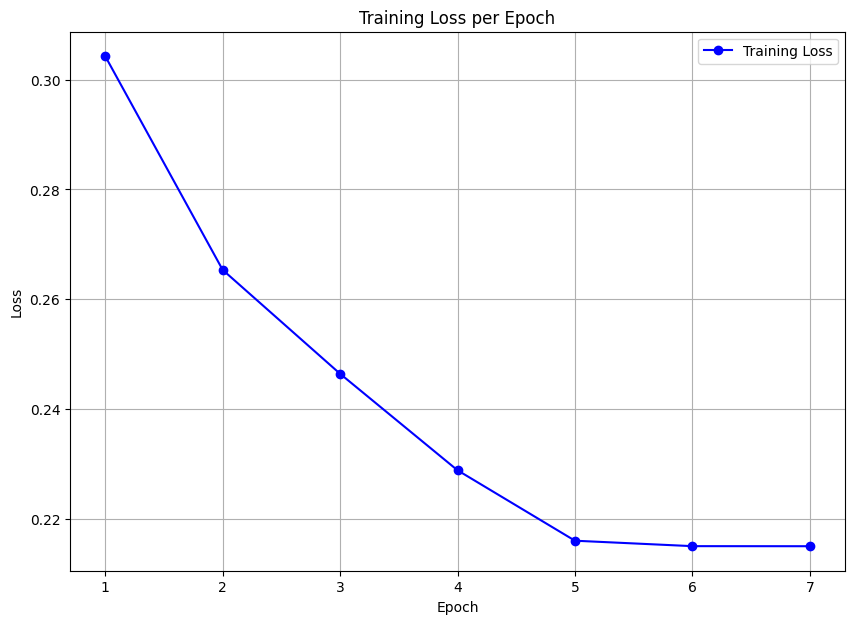

In [ ]:
import matplotlib.pyplot as plt
all_train_loss = [0.304252,0.265340,0.246423,0.228848,0.216023,0.215032,0.215019]
epochs = 5
# Plotting the training loss
plt.figure(figsize=(10, 7))
plt.plot(range(1, epochs+3), all_train_loss, marker='o', color='b', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model

In [ ]:
import torch
model_path = "albert_model.pth"
torch.save(model.state_dict(), model_path)


## Evaluation Setup

    

In [6]:
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, data_loader, criterion, device, mode):
    model.eval()
    model = model.to(device)
    total_loss = 0
    all_predictions = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc=mode, leave=False)

    with torch.no_grad():
      # if data_loader.dataset[0].keys() != {'review_text', 'input_ids', 'attention_mask', 'labels'}:
      #   print("Dataset keys:", data_loader.dataset[0].keys())
      #   raise ValueError("Dataset does not contain the expected keys")

      for batch in progress_bar:
          #review_text = batch['review_text'].to(device)
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          loss = criterion(outputs, labels)
          total_loss += loss.item()

          _, predicted = torch.max(outputs, dim=1)
          all_predictions.extend(predicted.cpu().tolist())
          all_labels.extend(labels.cpu().tolist())

          progress_bar.set_postfix(loss=loss.item())

    average_loss = total_loss / len(data_loader)
    f1 = f1_score(all_labels, all_predictions)

    # # Calculate confusion matrix
    # cm = confusion_matrix(all_labels, all_predictions)

    # # Plot confusion matrix
    # sns.heatmap(cm, annot=True, fmt='d')
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.show()

    return average_loss, f1


# Run Evaluation

In [ ]:
n_classes = 2
model = SentimentClassifier(n_classes)
model.load_state_dict(torch.load("albert_model.pth"))
val_loss, val_f1 = evaluate(model, val_data_loader, criterion, device, mode='Evaluating')
print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}')

Validation Loss: 0.2076, Validation F1 Score: 0.9543


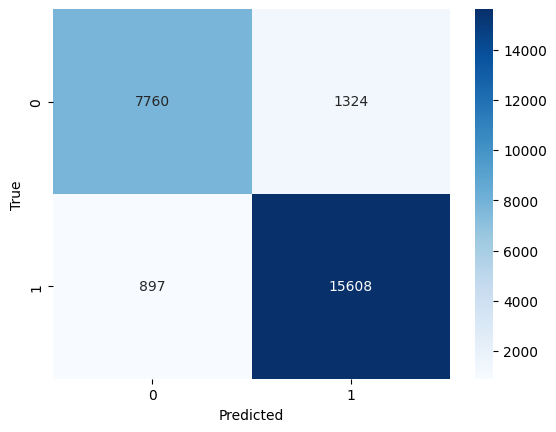

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Run Test

In [ ]:
df_test = pd.read_csv("Test.csv")
df_test = df_test.drop(columns=['Translated_Review', 'Review'])
print(df_test.head(5))

                                      Cleaned_Review  Sentiment  \
0                                              pepee          1   
1  painfully horrendous compared br popular battl...          0   
2                                                 ok          1   
3                                          nice game          1   
4                   copied things gmod team memebers          0   

                            Game  
0                   Apex Legends  
1  PlayerUnknown's Battlegrounds  
2                   Apex Legends  
3                 Team Fortress2  
4                 Team Fortress2  


In [ ]:
test_dataset = GameReviewDataset(df_test['Cleaned_Review'], df_test['Sentiment'], tokenizer, max_len)
test_data_loader = DataLoader(test_dataset, batch_size=32)

# Reuse the evaluate function for the test dataset
test_loss, test_f1 = evaluate(model, test_data_loader, criterion, device, mode='Testing')
print(f'Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}')

Test Loss: 0.2531, Test F1 Score: 0.9421


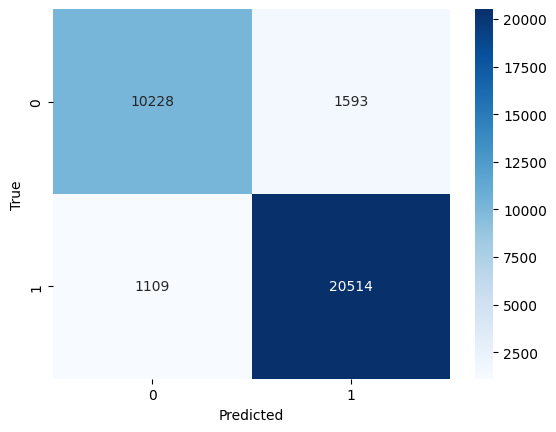

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [8]:
import torch
n_classes = 2
model = SentimentClassifier(n_classes)
model.load_state_dict(torch.load("albert_model.pth"))
print("load model successfully")

load model successfully


In [24]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification
import torch
from transformers import AlbertModel
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.albert = AlbertModel.from_pretrained('albert-base-v2')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.albert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.albert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

def import_data(model_file):
  n_classes = 2
  model = SentimentClassifier(n_classes)
  model.load_state_dict(torch.load(model_file))
  return model

def predict_class(model,review):
  model.eval()  # Put the model in evaluation mode

  # Load the tokenizer
  tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
  text = review
  # Tokenize the example text and create attention masks
  inputs = tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=128,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',  # Return PyTorch tensors
      truncation=True
  )

  # Get the input IDs and attention mask
  input_ids = inputs['input_ids']
  attention_mask = inputs['attention_mask']

  # Predict
  with torch.no_grad():  # No need to compute gradients for predictions
      outputs = model(input_ids, attention_mask=attention_mask)

  # The first element in the outputs is the logits
  logits = outputs[0]

  # Process the outputs
  probabilities = torch.nn.functional.softmax(logits, dim=-1)
  print(probabilities)

  # Get the highest probability class
  predicted_class = torch.argmax(probabilities, dim=-1).numpy()
  print(f"Predicted class: {predicted_class}")


model = import_data("albert_model.pth")
review = "Such a nice game"
predict_class(model,review)

tensor([0.0085, 0.9915])
Predicted class: 1
